In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/3


2/2 [==============================] - 61s 12s/step - loss: 0.7152 - accuracy: 0.5161 - val_loss: 0.7260 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 12s 7s/step - loss: 0.6716 - accuracy: 0.5806 - val_loss: 0.7320 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 11s 6s/step - loss: 0.6187 - accuracy: 0.7742 - val_loss: 0.7440 - val_accuracy: 0.5000
Accuracy: 0.5


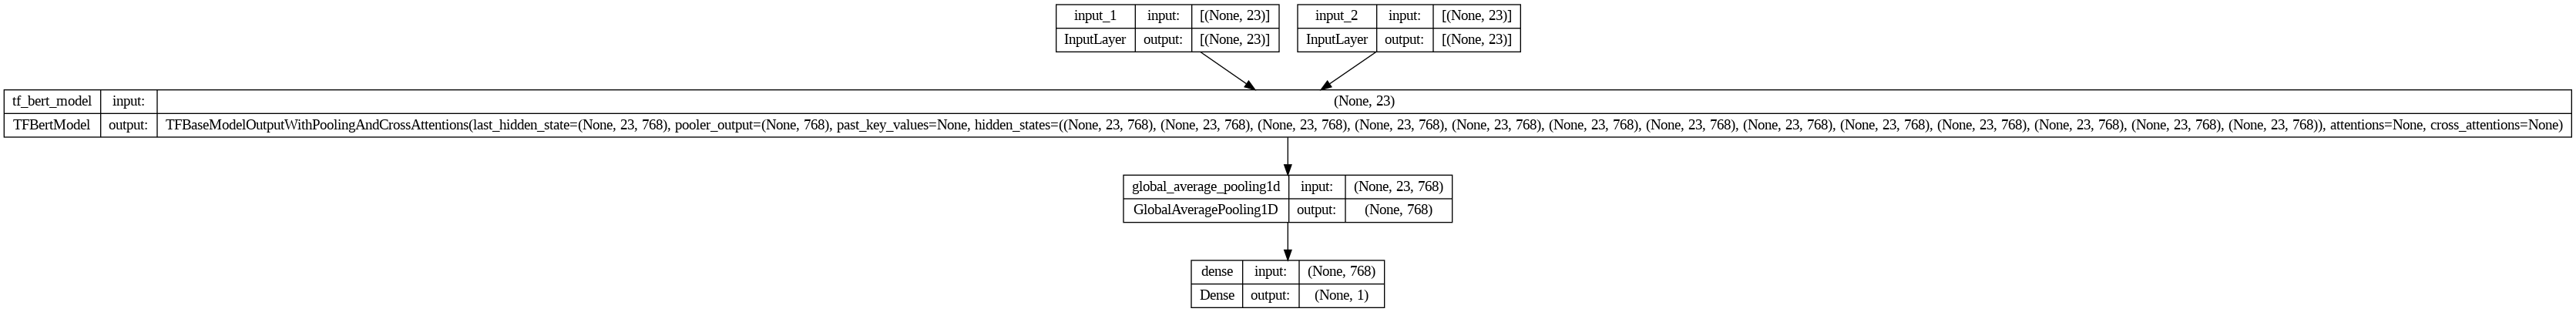

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from tensorflow.keras.utils import plot_model

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/DATASET/customer_review.csv')
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=42)

# Encode the labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text and determine the maximum sequence length
X_train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True)
X_test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True)
max_length = max(max(len(x) for x in X_train_encodings['input_ids']), max(len(x) for x in X_test_encodings['input_ids']))

# Re-tokenize with adjusted max_length
X_train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=max_length)
X_test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=max_length)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_1': X_train_encodings['input_ids'],
        'input_2': X_train_encodings['attention_mask'],
    },
    y_train.astype(float)
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_1': X_test_encodings['input_ids'],
        'input_2': X_test_encodings['attention_mask'],
    },
    y_test.astype(float)
))

# Load the pre-trained BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)


# Build the transformer-based model
input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_1')
attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_2')
embedding_layer = bert_model(input_ids, attention_mask=attention_mask)[0]
output_layer = tf.keras.layers.GlobalAveragePooling1D()(embedding_layer)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(output_layer)

model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output_layer)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(train_dataset.shuffle(1000).batch(16),
          epochs=3,
          batch_size=16,
          validation_data=test_dataset.shuffle(1000).batch(16))

# Evaluate the model
loss, accuracy = model.evaluate(test_dataset.batch(16), verbose=0)
print("Accuracy:", accuracy)

#plot
plot_model(model, to_file='model.png', show_shapes=True)